In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.time import Time
from astropy.timeseries import LombScargle
import exoplanet as xo

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
file = 'aavsodata_5f20eb1154bf8.txt'
df = pd.read_csv(file)
# df

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,15,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.columns

Index(['JD', 'Magnitude', 'Uncertainty', 'HQuncertainty', 'Band',
       'Observer Code', 'Comment Code(s)', 'Comp Star 1', 'Comp Star 2',
       'Charts', 'Comments', 'Transfomed', 'Airmass', 'Validation Flag',
       'Cmag', 'Kmag', 'HJD', 'Star Name', 'Observer Affiliation',
       'Measurement Method', 'Grouping Method', 'ADS Reference', 'Digitizer',
       'Credit'],
      dtype='object')

In [5]:
df.shape

(35447, 24)

In [6]:
df['Band'].unique()

array(['Vis.', 'V', 'U', 'B', nan, 'H', 'CV', 'TG', 'J', 'TB', 'TR', 'I',
       'R'], dtype=object)

In [7]:
df['Validation Flag'].unique()

array(['V', 'Z'], dtype=object)

In [8]:
df['Uncertainty'] < 1

0        False
1        False
2        False
3        False
4        False
         ...  
35442    False
35443     True
35444    False
35445    False
35446    False
Name: Uncertainty, Length: 35447, dtype: bool

In [9]:
vok = np.where((df['Uncertainty'] < 0.1) &          # select only "good" data
               (df['Band'] == 'V') &                # in V band
               (df['JD'] > (2459059.6638 - 40*365)) # within last ~40yrs
              )[0]

np.size(vok) # how many data points do we have?

1579

In [10]:
new_dates = Time(['2020-06-24', '2020-7-13', '2020-07-20'], format='isot', scale='utc')
new_mags = [0.66, 0.76, 0.80]
new_errs = [0.015, 0.015, 0.015]

In [11]:
time = Time(df['JD'].values[vok], format='jd')

In [12]:
XX = time.to_value('decimalyear')
YY = df['Magnitude'][vok].astype('float').values
EE = df['Uncertainty'][vok].values

XX = np.append(XX, new_dates.to_value('decimalyear'))
YY = np.append(YY, new_mags)
EE = np.append(EE, new_errs)

ss = np.argsort(XX)
XX = XX[ss]
YY = YY[ss]
EE = EE[ss]

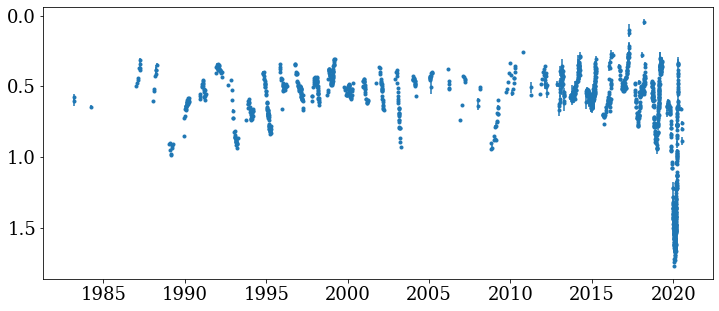

In [13]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')
plt.gca().invert_yaxis()

1.076339261791538


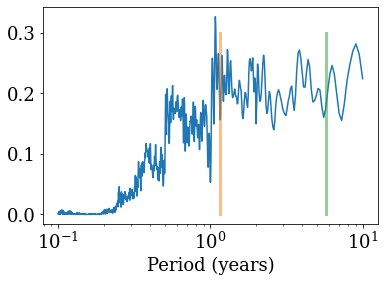

In [14]:
frequency, power = LombScargle(XX, YY).autopower(minimum_frequency=1./10, maximum_frequency=1./0.1)
plt.plot(1./frequency, power)
plt.xscale('log')
plt.plot([420/365., 420/365.], [0,0.3], c='C1', lw=3, alpha=0.5) # Dupree+(1987)
plt.plot([5.78, 5.78], [0,0.3], c='C2', lw=3, alpha=0.5) # Goldberg(1984)

plt.xlabel('Period (years)')

# Uh oh, that 1-yr alias...
print(1./frequency[np.argmax(power)])

Now let try the ACF

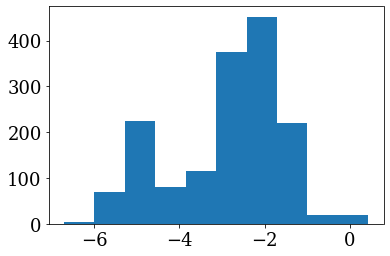

In [15]:
# There's a problem we run in to... there are datapoints with the same timestamps,
# and the delta-time distribution is very wide...
dok = np.where((np.diff(XX) > 0.00))[0]
_ = plt.hist(np.log10(np.diff(XX)[dok]))

In [16]:
# This is an issue b/c the ACF estimator resamples the data onto a uniform grid
# based on the minimum delta-time... making 40yrs @ minutes cadence SUPER slow 

dok = np.where((np.diff(XX) > 1e-4))[0]

acf = xo.autocorr_estimator(XX[dok], YY[dok], yerr=EE[dok], oversample=1,
                            min_period=0.01, max_period=5, max_peaks=3)


(0.0, 15.0)

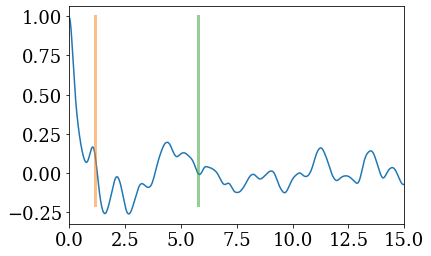

In [17]:
# Hmm, also doesn't get the right period quite... still loves that 1-yr alias!
plt.plot(acf['autocorr'][0],acf['autocorr'][1])
plt.plot([420/365., 420/365.], [-.2,1], c='C1', lw=3, alpha=0.5) # Dupree+(1987)
plt.plot([5.78, 5.78], [-.2,1], c='C2', lw=3, alpha=0.5) # Goldberg(1984)

plt.xlim(0,15)

In [18]:
acf['peaks']

[{'period': 1.0381849347083971, 'period_uncert': nan}]

In [19]:
EE

array([0.024, 0.033, 0.011, ..., 0.015, 0.015, 0.03 ])

In [34]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    mean = pm.Normal("mean", mu=np.mean(YY), sd=1)
    yerr = pm.Normal("yerr", mu=np.mean(EE), sd=1)    
    logamp = pm.Normal("logamp", mu=np.log(np.var(YY)), sd=1)
    period = pm.Uniform("period", lower=0.0, upper=2.0)
    logQ0 = pm.Normal("logQ0", mu=0.5, sd=5.0)
    logdQ = pm.Normal("logdQ", mu=2.0, sd=5.0)
    mix = pm.Uniform("mix", lower=0.0, upper=1.0)
    
    logS0 = pm.Normal("logS0", mu=np.log(np.var(YY)), sd=5)
    dt = XX[-1] - XX[0]
    lower = -np.log(dt / 2 / np.pi)
    upper = -np.log(dt / 40 / np.pi)
    logw = pm.Uniform("logw", lower=lower, upper=upper)
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdQ,
        mix=mix
    )
    kernel += xo.gp.terms.SHOTerm(
        log_S0 = logS0,
        log_w0 = logw,
        log_Q = -np.log(np.sqrt(2))
    )                  
                      
    gp = xo.gp.GP(kernel, XX, yerr**2 * np.ones_like(XX), mean=mean, J=6)
    gp.marginal("gp", observed = YY)

    start = model.test_point
    map_soln = xo.optimize(start=start, verbose=True)
    trace = pm.sample(
        tune=500,
        draws=500,
        start=start,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

optimizing logp for variables: [logw, logS0, mix, logdQ, logQ0, period, logamp, yerr, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -3046.0471433932908 -> -1247.0860050478054
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logw, logS0, mix, logdQ, logQ0, period, logamp, yerr, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [03:48<00:00, 13.73draws/s]


In [21]:
map_soln

{'mean': array(0.70399654),
 'yerr': array(0.68604515),
 'logamp': array(-3.06157786),
 'period_interval__': array(5.02562813),
 'logQ0': array(-3.22163137),
 'logdQ': array(-49.81001647),
 'mix_interval__': array(-11.90301413),
 'logS0': array(-108.34710432),
 'logw_interval__': array(9.93820707),
 'period': array(1.98695078),
 'mix': array(6.7699226e-06),
 'logw': array(1.21203292)}

In [35]:
trace[1]

{'mean': 0.5411052576488274,
 'yerr': 0.03686769026462313,
 'logamp': -4.405193394326446,
 'period_interval__': 0.14589720354727317,
 'logQ0': 0.9126255946377857,
 'logdQ': 1.5851953548963391,
 'mix_interval__': 1.2333345552381174,
 'logS0': -4.574732279538648,
 'logw_interval__': 1.9308559756126125,
 'period': 1.0728194779944826,
 'mix': 0.7744016664856681,
 'logw': 0.8327505225182805}

In [ ]:
pm.traceplot(trace)

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

In [68]:
t = np.linspace(XX[0], XX[-1]+2, 1000)
with model:
    mu, var = xo.eval_in_model(gp.predict(t, return_var=True), trace[1])

(2010.0, 2022.0)

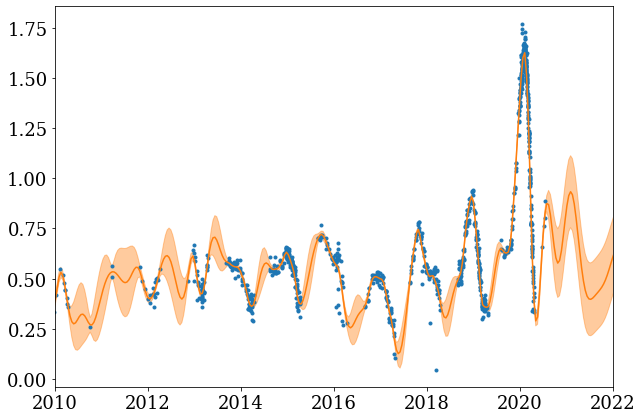

In [70]:
plt.figure(figsize=(10, 7))
plt.plot(XX, YY, '.')
plt.plot(t, mu+trace[1]['mean'])
plt.fill_between(t, mu-np.sqrt(var)+trace[1]['mean'], 
                 mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C1')
plt.xlim(2010, 2022)

In [ ]:
with model:
    mu, var = xo.eval_in_model(gp.predict(XX, return_var=True), map_soln)

In [ ]:
import celerite
from celerite import terms
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp,):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

In [ ]:
bounds = dict(log_S0=(-0, 15), log_Q=(-15, 15), log_omega0=(-15, 15))

EPAD = 0.02 # add extra Yerror term to "account" for scatter

Q = 1.0 / np.sqrt(2.0)
w0 = .01
S0 = np.var(YY) / (w0 * Q)
#kernel = xo.gp.terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), 
                       log_omega0=np.log(w0), bounds=bounds)
#kernel.freeze_parameter("log_Q") 
#kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), 
#                       log_omega0=np.log(w0), bounds=bounds)
# kernel += terms.RealTerm(log_a=np.log(np.var(YY)), log_c=-np.log(10.0))

gp = celerite.GP(kernel, mean=np.mean(YY), fit_mean=True)
gp.compute(XX, yerr=EE + EPAD) 

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()

soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method='L-BFGS-B', bounds=bounds, args=(YY, gp))
gp.set_parameter_vector(soln.x)

xnew = np.linspace(XX.min(), 2022, 1500)
mu, var = gp.predict(YY, xnew, return_var=True)

In [ ]:
gp.get_parameter_dict()

In [ ]:
# This gives us... some other period entirely right now. Huh... 2.7yrs??
print(2*np.pi/np.exp(gp.get_parameter_dict()['kernel:terms[0]:log_omega0']))

In [ ]:
# But, the model looks nice!

plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, 
             yerr=EE, linestyle='none', marker='.')

plt.plot(xnew, mu)
plt.fill_between(xnew, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
                 edgecolor="none")
plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')



In [ ]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, 
             yerr=EE, linestyle='none', marker='.')

plt.plot(xnew, mu)
plt.fill_between(xnew, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
                 edgecolor="none")
plt.gca().invert_yaxis()
# plt.xlim(2005,2022)
plt.ylabel('V mag')

So what if we try something else to recover the 430d period...

let's run the Lomb-Scargle and ACF on the GP predictions, which are regularly sampled (no 1-yr observing alias)

In [ ]:
# If we start getting selective about the time range, we can pick periods we "like" 
# (i.e. match previous results )
# NOTE: This is unsatisfying...

aok = np.where((xnew > 1994))[0]

frequency,power = LombScargle(xnew[aok], mu[aok]).autopower(minimum_frequency=1./10, maximum_frequency=1./0.1)
plt.plot(1./frequency, power)
plt.xscale('log')
plt.plot([420/365., 420/365.], [0,.3], c='C1', lw=3, alpha=0.5) # Dupree+(1987)
plt.plot([5.78, 5.78], [0,.3], c='C2', lw=3, alpha=0.5) # Goldberg(1984)

plt.xlabel('Period (years)')

print(1./frequency[np.argmax(power)])

In [ ]:
aok = np.where((xnew > 1994) & (xnew < 2004))[0]

frequency,power = LombScargle(xnew[aok], mu[aok]).autopower(minimum_frequency=1./10, maximum_frequency=1./0.1)
plt.plot(1./frequency, power)
plt.xscale('log')
plt.plot([420/365., 420/365.], [0,.3], c='C1', lw=3, alpha=0.5) # Dupree+(1987)
plt.plot([5.78, 5.78], [0,.3], c='C2', lw=3, alpha=0.5) # Goldberg(1984)

plt.xlabel('Period (years)')

print(1./frequency[np.argmax(power)])